# 第3章 从零开始搭建扩散模型

## 3.1 环境准备

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


使用一个非常小的经典数据集mnist来进行测试。

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 7, 2, 2, 2, 2, 0, 1])


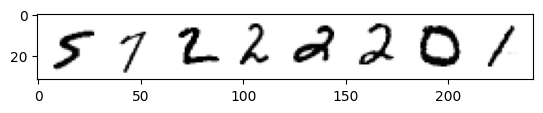

In [2]:
dataset = torchvision.datasets.MNIST(root="./data/mnist/", train=True, download=True, 
                                     transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## 3.2 扩散模型之退化过程

退化过程就是添加噪声的过程。

In [3]:
def corrupt(x, amount):
    """根据amount为输入x加入噪声，这就是退化过程"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1) 
    return x*(1-amount) + noise*amount 

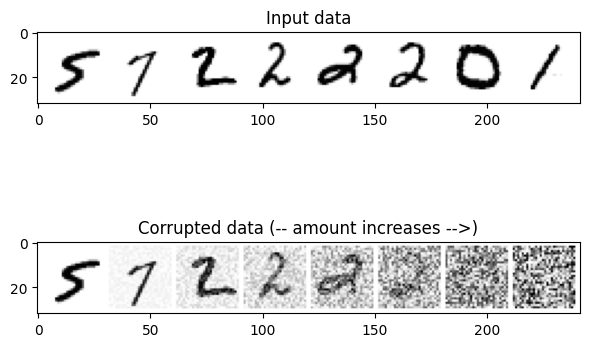

In [4]:
# 绘制输入数据
fig, axs = plt.subplots(2, 1, figsize=(7, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 加入噪声
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# 绘制加噪版本的图像
axs[1].set_title('Corrupted data (-- amount increases -->)')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys');

## 3.3 扩散模型的训练

模型接收一个单通道图像，并通过下行路径上的三个卷积层（图和代码中的`down_layers`）和上行路径上的3个卷积层，在下行和上行层之间具有残差连接。使用最大池化层进行下采样和`nn.Upsample`用于上采样。

![](images/ch03-01.png)

In [46]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        # 激活函数
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            # 通过运算层与激活函数
            x = self.act(l(x))
            if i < 2:
                # 排列供残差连接使用的数据
                h.append(x) 
                # 连接下采样
                x = self.downscale(x) 
              
        for i, l in enumerate(self.up_layers):
            if i > 0: 
                # 连接上采样
                x = self.upscale(x) 
                # 得到之前排列好的供残差连接使用的数据
                x += h.pop()
            x = self.act(l(x)) 
            
        return x

In [47]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

In [48]:
# 网络的参数个数
sum([p.numel() for p in net.parameters()])

309057

In [49]:
# 训练数据加载器
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

In [50]:
# 创建UNet网络
net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

In [51]:
losses = []

# 开始训练
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        # 得到数据并准备退化
        x = x.to(device)
        # 随机噪声
        noise_amount = torch.rand(x.shape[0]).to(device) 
        # 退化过程
        noisy_x = corrupt(x, noise_amount) 
        
        # 得到预测结果
        pred = net(noisy_x)
        
        # 计算损失值
        loss = loss_fn(pred, x) 
        
        # 反向传播并更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    
    # 输出损失的均值
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.026962
Finished epoch 1. Average loss for this epoch: 0.020560
Finished epoch 2. Average loss for this epoch: 0.018586


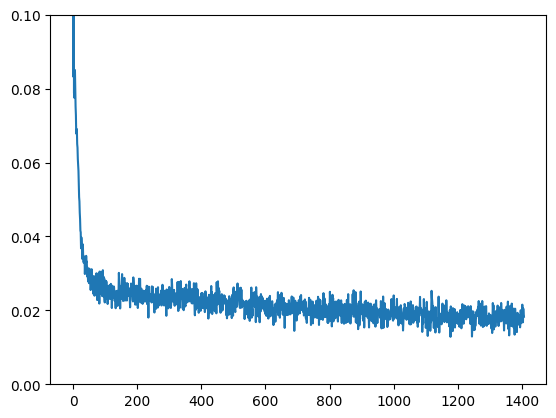

In [52]:
# 绘制损失曲线
plt.plot(losses)
plt.ylim(0, 0.1);

对比输入数据、退化数据、预测数据：

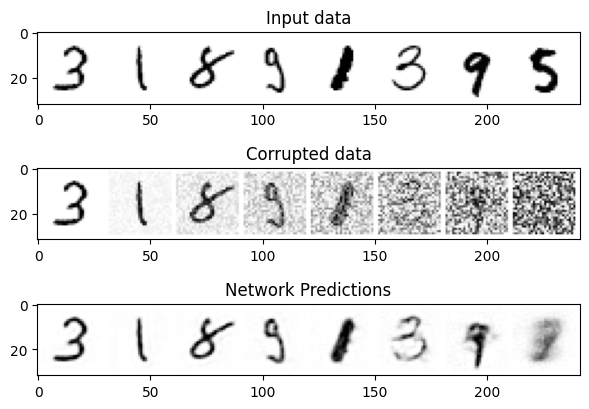

In [35]:
x, y = next(iter(train_dataloader))
# 只取前8个数
x = x[:8]

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# 绘制对比图    
fig, axs = plt.subplots(3, 1, figsize=(7, 5))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys');

## 3.4 扩散模型的采样过程

### 3.4.1 采样过程

采样过程的方案：从完全随机的噪声开始，先检查一下模型的预测结果，然后只朝着预测方向移动一小部分。

In [11]:
def sample_with_step(x, n_steps):
    step_history = [x.detach().cpu()]
    pred_output_history = []

    for i in range(n_steps):
        with torch.no_grad(): 
            pred = net(x) 
        # 将模型输出保存下来    
        pred_output_history.append(pred.detach().cpu())
        # 朝着预测方向移动的因子
        mix_factor = 1/(n_steps - i) 
        x = x*(1-mix_factor) + pred*mix_factor 
        step_history.append(x.detach().cpu()) 
    
    return x, step_history, pred_output_history

In [26]:
n_steps = 5
# 完全随机的值开始
x = torch.rand(8, 1, 28, 28).to(device)
x, step_history, pred_output_history = sample_with_step(x, n_steps)

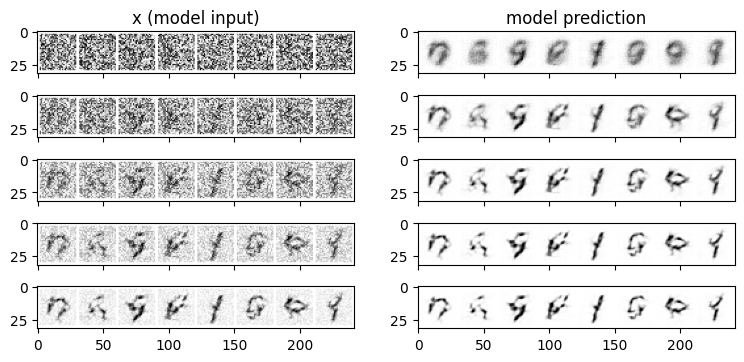

In [27]:
fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0,0].set_title('x (model input)')
axs[0,1].set_title('model prediction')
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

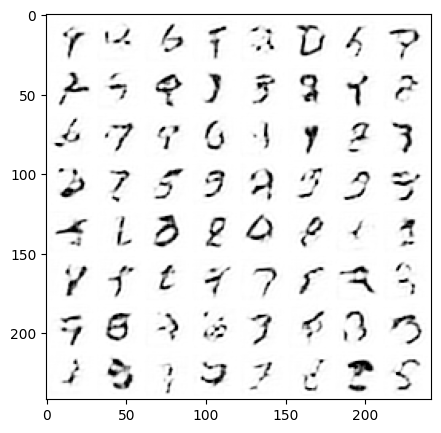

In [30]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)

x, _, _ = sample_with_step(x, n_steps)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')

### 3.4.2 UNet2DModel

UNet2DModel与DDPM对比：
- UNet2DModel比BasicUNet更先进。
- 退化过程的处理方式不同。
- 训练目标不同，包括预测噪声而不是去噪图像。
- UNet2DModel模型通过调节时间步来调节噪声量, 其中$t$作为一个额外参数传入前向过程中。

Diffusers库中的UNet2DModel模型比BasicUNet模型有如下改进：

- GroupNorm层对每个模块的输入进行了组标准化（group normalization）。
- Dropout层能使训练更平滑。
- 每个块有多个ResNet层（如果layers_per_block未设置为1）。
- 引入了注意力机制（通常仅用于输入分辨率较低的blocks）。
- 可以对时间步进行调节。
- 具有可学习参数的上采样模块和下采样模块。

In [5]:
net = UNet2DModel(
    sample_size=28,           # 目标图像的分辨率
    in_channels=1,            
    out_channels=1,           
    layers_per_block=2,       # 每一个UNet块中的ResNet层数
    block_out_channels=(32, 64, 64), 
    down_block_types=( 
        "DownBlock2D",        # 下采样模块
        "AttnDownBlock2D",    # 带有空域维度的self-att的ResNet下采样模块
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",      # 带有空域维度的self-att的ResNet上采样模块
        "UpBlock2D",          # 上采样模块
      ),
)

In [6]:
sum([p.numel() for p in net.parameters()])

1707009

UNet2DModel模型大约有170万个参数，而BasicUNet模型只有30多万个参数。

In [8]:
# 训练数据加载器
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

n_epochs = 3

net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

losses = []

# 开始训练
for epoch in range(n_epochs):

    for x, y in train_dataloader:
        # 得到数据并准备退化
        x = x.to(device)
        # 随机噪声
        noise_amount = torch.rand(x.shape[0]).to(device) 
        # 退化过程
        noisy_x = corrupt(x, noise_amount) 
        
        # 得到预测结果
        pred = net(noisy_x, 0).sample
        
        # 计算损失值
        loss = loss_fn(pred, x) 
        
        # 反向传播并更新参数
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
    
    # 输出损失的均值
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.018765
Finished epoch 1. Average loss for this epoch: 0.012869
Finished epoch 2. Average loss for this epoch: 0.011522


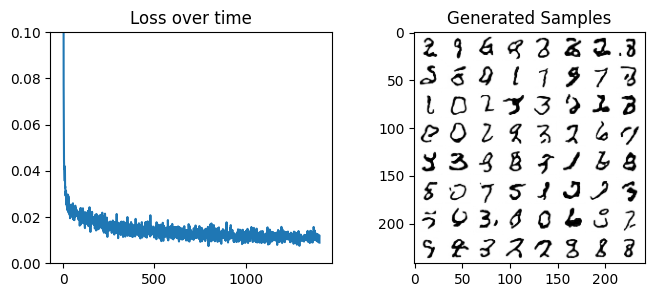

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title('Loss over time')

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

axs[1].imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Generated Samples');

## 3.5 扩散模型的退化过程示例

**退化过程：**
 
在某个时间步给定 $x_{t-1}$，可以得到一个噪声稍微增加的 $x_t$：
$$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t I) 
q(x_{1:T} | x_0) = \prod^T_{t=1} q(x_t | x_{t-1})
$$

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


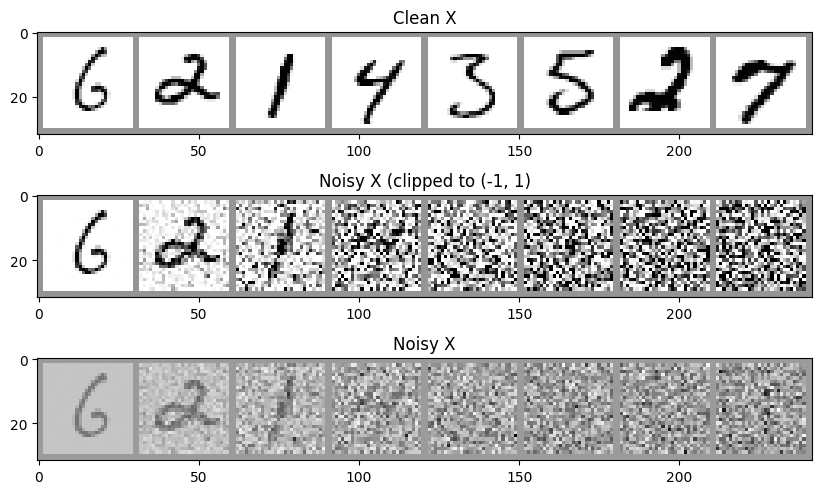

In [20]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

# 对一批图片加噪
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1.
print('X shape', xb.shape)

# 展示干净的原始输入图片
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# 使用调度器加噪
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)

# 展示“带噪”版本
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');

- 模型会预测退化过程中使用的噪声。
- 预测噪声这个目标会使权重更倾向于预测得到更低的噪声量。

## 3.6 扩展知识

- 时间步可以转换为embedding，在多个地方被输入模型。
- 输入纯噪声，在模型预测的基础上使用足够多的小步，不断迭代，每次去除一点点噪声。